In [6]:
import os
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from skimage.draw import polygon


## helper functions

In [7]:
def ind2sub(array_shape, ind):
    rows, cols = array_shape
    row = (ind - 1) % rows
    col = (ind - 1) // rows
    return row, col


def load_mat_data(sampleID, celltype_dir, segmentation_dir):
    celltype_data = sio.loadmat(os.path.join(celltype_dir, sampleID))
    segmentation_data = sio.loadmat(os.path.join(segmentation_dir, sampleID))

    celltype_keys = [k for k in celltype_data.keys() if not k.startswith('__')]
    nuc_keys = [k for k in segmentation_data.keys() if not k.startswith('__')]

    print(f"CellType fields: {celltype_keys}")
    print(f"Segmentation fields: {nuc_keys}")

    return celltype_data['cellTypes'], segmentation_data['Boundaries'], segmentation_data['nucleiImage']


def create_celltype_image(nucleiImage, Boundaries, CellType, color_map_df):
    celltype_image = np.zeros((*nucleiImage.shape, 3), dtype=np.uint8)

    for idxCellType in range(CellType.shape[0]):
        curCellType = CellType[idxCellType][0][0]
        matches = color_map_df[color_map_df['CellTypes'] == curCellType]

        if matches.empty:
            print(f"Missing color for: {curCellType}")
            continue

        curColor = matches[['R', 'G', 'B']].values.astype(np.uint8)[0]
        curInds = Boundaries[0][idxCellType]

        coords = [ind2sub(nucleiImage.shape, inds[0]) for inds in curInds]
        rr = np.array([c[1] for c in coords])  # rows = y
        cc = np.array([c[0] for c in coords])  # cols = x

        try:
            poly_y, poly_x = polygon(rr, cc, shape=nucleiImage.shape)
            celltype_image[poly_y, poly_x] = curColor
        except Exception as e:
            print(f"Polygon fill failed for cell {idxCellType}: {e}")

    return celltype_image


def plot_nuclei_boundaries(ax, nucleiImage, Boundaries):
    ax.imshow(nucleiImage, cmap='gray')
    for idxNuc in range(len(Boundaries[0])):
        curInds = Boundaries[0][idxNuc]
        coords = [ind2sub(nucleiImage.shape, inds[0]) for inds in curInds]
        cx = [c[0] for c in coords]
        cy = [c[1] for c in coords]
        ax.plot(cy, cx, linewidth=1)
    ax.axis('off')
    ax.set_title("Nuclei with Boundaries")


def visualize_results(nucleiImage, Boundaries, celltype_image):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(nucleiImage, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Nuclei Image")

    plot_nuclei_boundaries(axs[1], nucleiImage, Boundaries)

    axs[2].imshow(celltype_image)
    axs[2].axis('off')
    axs[2].set_title("Cell Type Image")

    plt.tight_layout()
    plt.show()


## configuration and plots

In [8]:
DIR_CELLTYPE = 'CellType'
DIR_SEGMENTATION = 'Segmentation'
celltype_colorMapping_file = 'allCellTypesRGBMapping.xlsx'

In [9]:
sample_list = os.listdir(DIR_CELLTYPE)
print(len(sample_list))
df_celltype_colorMapping = pd.read_excel(celltype_colorMapping_file)
df_celltype_colorMapping.head()

125


,CellTypes,CellTypesMapping,R,G,B
0,Brain tumor,Brain tumor,220,220,220
1,B cells,B cells,17,38,191
2,Cl MG,Cl MG,255,203,0
3,Alt MG,Alt MG,251,132,4
4,Alt MDM,Alt MDM,251,62,4


CellType fields: ['cellTypes']
Segmentation fields: ['Boundaries', 'nucleiImage', 'occupancy_image', 'nucleiOccupancyIndexed']


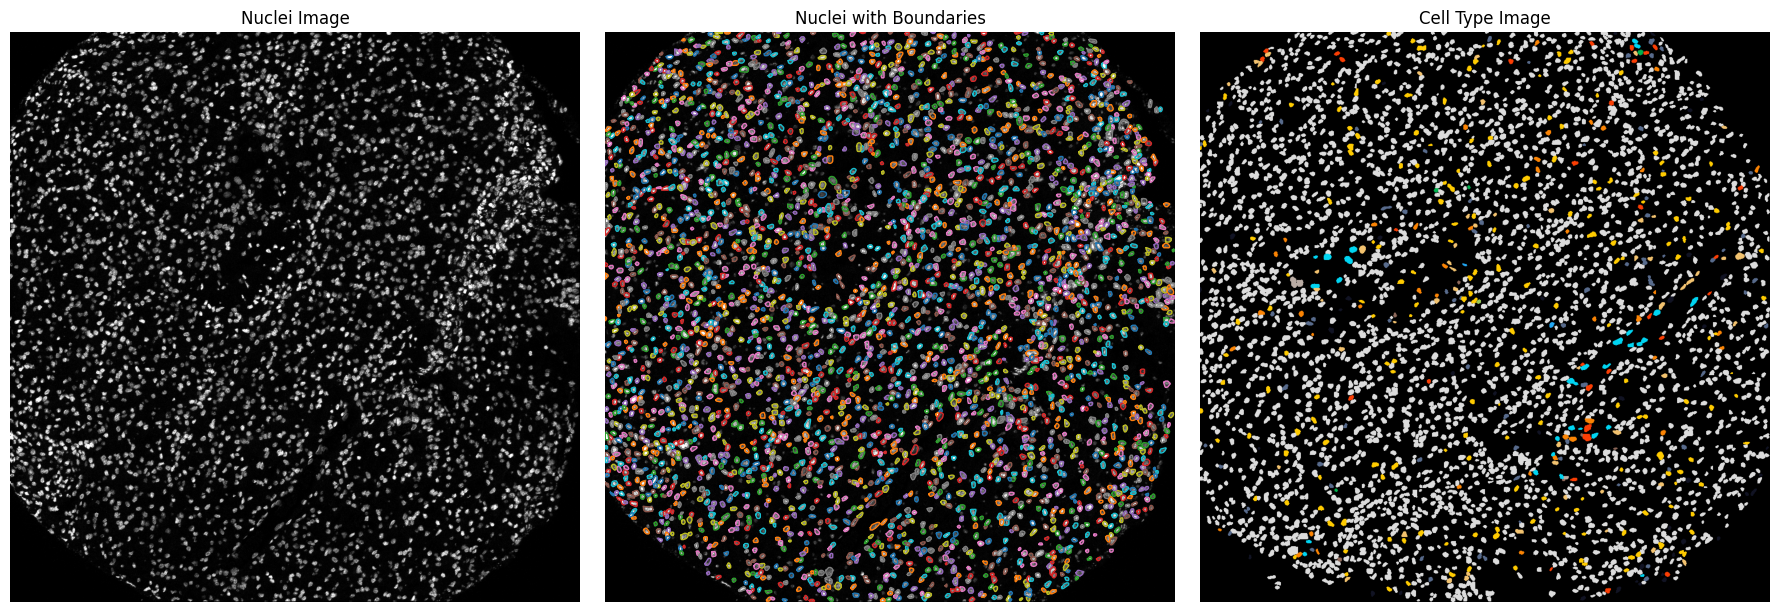

In [ ]:
sampleID = sample_list[4]

# load data
CellType, Boundaries, nucleiImage = load_mat_data(
    sampleID, DIR_CELLTYPE, DIR_SEGMENTATION
)

# create colored celltype image
celltype_image = create_celltype_image(nucleiImage, Boundaries, CellType, df_celltype_colorMapping)

# visualize
visualize_results(nucleiImage, Boundaries, celltype_image)
